# CS4248 Project - Labelled Unreliable News (LUN)

## Imports

In [45]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

In [46]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stemmer = None
# lemmatizer = None

TEST_SIZE = 0.1
SMOOTHING = 1.0
NGRAM_RANGE = (1, 1)

## Helper Functions

In [47]:
def preprocess(sentence, lower_case=True, remove_punctuation=True, replace_contractions=True):
    if lower_case:
        sentence = sentence.lower()
    if remove_punctuation:
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    if replace_contractions:
        news = sentence.split()
        new_news = []
        for word in news:
            if word in contractions:
                new_news.append(contractions[word])
            else:
                new_news.append(word)
        sentence = " ".join(new_news)
    return sentence

In [48]:
def tokenize(sentence, stemmer=stemmer, lemmatizer=lemmatizer, remove_stop_words=False):
    tokens = word_tokenize(sentence)
    
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words]
    if stemmer:
        tokens = [stemmer.stem(token) for token in tokens]
    if lemmatizer:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
    return tokens

## Load Data

In [49]:
full_train_df = pd.read_csv('raw_data/fulltrain.csv', header=None)
full_train_df.columns = ['label', 'text']
full_train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [50]:
train_df = full_train_df.drop_duplicates(subset=['text'])
print(f"No. training samples (all classes): {len(train_df)}")

No. training samples (all classes): 48652


## Training

In [51]:
X = train_df['text'].values
y = train_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)
X_train.shape, X_test.shape

((43786,), (4866,))

In [52]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, smooth_idf=True, preprocessor=preprocess, tokenizer=tokenize, token_pattern=None)
# Uncomment for default TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, smooth_idf=True)

In [53]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(feature_names)}")
print(feature_names[:150])

Vocabulary size: 287057
['0' '00' '000' '0000' '000000' '00000000' '00000000000000'
 '0000000000000001834' '00000000001' '0000000001ounce' '000000003'
 '00000001' '0000000rom' '0000001' '0000004' '000001' '00000138'
 '00000153' '00000186' '000002' '000004' '000005' '000006' '0000068'
 '00001' '00001010' '000013s' '000015' '000016' '00003' '00004' '00005'
 '00007' '0000gmt' '0000hrs' '0001' '00010'
 '00010010101010101010101010101010' '00010052' '0001111' '000125' '00016'
 '00016925' '000185' '0001er' '0001ers' '0001erspredictable' '0001that'
 '0001which' '00020004' '0003' '00030' '00033' '00034' '0004' '00049'
 '0005' '00050860' '00053' '000567kln00067q' '0006' '0007' '00071'
 '0007149' '0008' '00080' '000fold' '000s' '000x' '001' '0010' '00100000'
 '00100001' '001000011011010101010101010101010101010010' '00101110' '0015'
 '0016' '0018' '0019' '001as' '001delivering' '001ers' '001essentially'
 '001mwcm2' '001s' '001same' '001that' '001unfuknbeeeleeevable' '002'
 '0021' '00226' '0025' '0

In [54]:
print(X_train_tfidf.shape)
print(X_train_tfidf)

(43786, 287057)
  (0, 19243)	0.06228037137564887
  (0, 17490)	0.047131398921413464
  (0, 21182)	0.06228037137564887
  (0, 213159)	0.022438264955753927
  (0, 48866)	0.043107901331845395
  (0, 29994)	0.03497361987001771
  (0, 54665)	0.017491060155421477
  (0, 56016)	0.016107396006457345
  (0, 34728)	0.048959900575351684
  (0, 6680)	0.018517857479427826
  (0, 630)	0.018009742697625838
  (0, 163447)	0.021167670007759626
  (0, 279676)	0.027837730905439256
  (0, 173365)	0.07770955198058324
  (0, 4836)	0.037897970811578245
  (0, 14640)	0.02061631588966255
  (0, 56536)	0.029259568056674932
  (0, 94314)	0.011674792652959566
  (0, 66111)	0.02906307540372125
  (0, 258015)	0.056877835687428116
  (0, 213503)	0.015154253465198171
  (0, 52731)	0.008114416114198593
  (0, 134090)	0.03645305696911107
  (0, 42247)	0.012222576232641578
  (0, 136050)	0.024303535980486433
  :	:
  (43785, 187968)	0.03801152260274759
  (43785, 103791)	0.02791798374294524
  (43785, 34081)	0.05821512825753399
  (43785, 151482)	

## Logistic Regression

In [55]:
clf = LogisticRegression(random_state=0, max_iter=200).fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.9831681359338601
F1 score: 0.9820999113739548


/Users/danelynn/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
# Commented out because take too long to run
"""
def getForwardKfeatures(k):
    # create SKL estimator
    logreg = LogisticRegression(random_state=0, max_iter=200)
    
    # call Forward selector and fit 
    sfs = SequentialFeatureSelector(logreg, n_features_to_select=k, direction = 'forward')
    sfs.fit(X_train_tfidf, y_train)
    
    # this is the set of chosen selectors (boolean array)
    sfs.get_support()

    # pick out the selected ones in the training set
    current_X = X_train_tfidf.iloc[:,sfs.get_support()]
    
    # fit the linear model 
    logreg.fit(current_X, y_train)

    # get the AUC score and return
    AUC = skm.roc_auc_score(y_train, model.predict_proba(current_X)[:, 1])
    
    return {"model":logreg, "AUC":AUC, "Npred":k, "features": sfs.get_support()}
"""

'\ndef getForwardKfeatures(k):\n    # create SKL estimator\n    logreg = LogisticRegression(random_state=0, max_iter=200)\n    \n    # call Forward selector and fit \n    sfs = SequentialFeatureSelector(logreg, n_features_to_select=k, direction = \'forward\')\n    sfs.fit(X_train_tfidf, y_train)\n    \n    # this is the set of chosen selectors (boolean array)\n    sfs.get_support()\n\n    # pick out the selected ones in the training set\n    current_X = X_train_tfidf.iloc[:,sfs.get_support()]\n    \n    # fit the linear model \n    logreg.fit(current_X, y_train)\n\n    # get the AUC score and return\n    AUC = skm.roc_auc_score(y_train, model.predict_proba(current_X)[:, 1])\n    \n    return {"model":logreg, "AUC":AUC, "Npred":k, "features": sfs.get_support()}\n'

In [70]:
"""
models_fwd = []
for i in range(1, len(feature_names)):
    models_fwd.append(getForwardKfeatures(i))
models_fwd = pd.DataFrame(models_fwd)
models_fwd.head()
"""

'\nmodels_fwd = []\nfor i in range(1, len(feature_names)):\n    models_fwd.append(getForwardKfeatures(i))\nmodels_fwd = pd.DataFrame(models_fwd)\nmodels_fwd.head()\n'

In [71]:
"""
row_index = models_fwd['AUC'].idxmax()
features = models_fwd.iloc[row_index]['features']
best_model_forward_stepwise = LogisticRegression(penalty="none", max_iter=5000).fit(X_train_tfidf.iloc[:,features], y_train)
"""

'\nrow_index = models_fwd[\'AUC\'].idxmax()\nfeatures = models_fwd.iloc[row_index][\'features\']\nbest_model_forward_stepwise = LogisticRegression(penalty="none", max_iter=5000).fit(X_train_tfidf.iloc[:,features], y_train)\n'

### Testing

In [ ]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = clf.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

### Validation

In [57]:
# Label 1
satire_sentence = "If voting changed anything, they would make it illegal."		

# Label 2
hoax_sentence = "In a recent turn of events, Obama has declared that he will be joining the Republican Party, partnering with Donald Trump."	

X_val = [satire_sentence, hoax_sentence]
X_test_tfidf = tfidf_vectorizer.transform(X_val)
y_pred_val = clf.predict(X_test_tfidf)
y_pred_val

array([3, 2])

In [58]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
1608,3,"As with many cities, water fluoridation has b..."
2203,3,June is National Fresh Fruit and Vegetable Mo...
2475,4,In a decision with important ramifications for...
2631,4,You could forgive your digital camera for feel...
2827,4,This week is as enormous as they come for econ...


In [59]:
X_val = test_df['text'].values
y_val = test_df['label'].values
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_val_tfidf.shape

(3000, 287057)

In [60]:
y_pred_val = clf.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.7426666666666667
F1 score: 0.7295067837727297


In [61]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.85      0.83      0.84       750
        hoax       0.85      0.38      0.53       750
  propaganda       0.59      0.86      0.70       750
    reliable       0.82      0.89      0.85       750

    accuracy                           0.74      3000
   macro avg       0.77      0.74      0.73      3000
weighted avg       0.77      0.74      0.73      3000



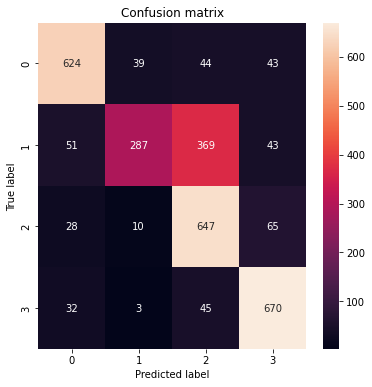

In [62]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	

## Naive Bayes

In [63]:
nb = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.6451833919517654
F1 score: 0.5229279152875014


### Testing

In [65]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = nb.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.6175503493629264
F1 score: 0.4842607688159718


### Validation

In [66]:
y_pred_val = nb.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.354
F1 score: 0.2710472662054557


In [67]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.64      0.28      0.39       750
        hoax       1.00      0.00      0.01       750
  propaganda       0.29      1.00      0.45       750
    reliable       1.00      0.14      0.24       750

    accuracy                           0.35      3000
   macro avg       0.73      0.35      0.27      3000
weighted avg       0.73      0.35      0.27      3000



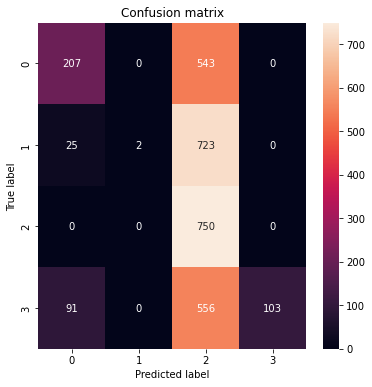

In [68]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	